In [673]:
from time import time, sleep
from datetime import date

from requests import get
import json

from multiprocessing.pool import ThreadPool as Pool

import haversine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def vehicle_df_creator(vehicles):
    
    vehicles_df = pd.DataFrame(vehicles['list']).drop(['stale', 'serviceDate', 'stopSequence', 'lastUpdateTime', 'status', 'congestionLevel', 'bearing', 'capacity', 'stopDistancePercent', 'wheelchairAccessible', 'style', 'deviated'], 1)
    vehicles_df = pd.concat([vehicles_df, pd.json_normalize(vehicles_df['location'])], 1)

    vehicles_df = vehicles_df.merge(routes, left_on = 'routeId', right_on = 'id', how = 'left')
    vehicles_df.drop(['location', 'type', 'routeId', 'id'], 1, inplace = True)
    vehicles_df.rename(columns = {'name' : 'Megálló'}, inplace = True)

    return vehicles_df


    
def get_trip_details(i):
    
    trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + i + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
    trip_data = get(trip_link, headers = headers).json()
    
    if 'data' in trip_data.keys():
        trip_data = trip_data['data']
        
        trip_id = i
    
        if 'vehicle' in trip_data['entry'].keys():
            route_id = trip_data['entry']['vehicle']['routeId']    
        else:
            route_id = np.nan

        if 'stopSequence' in trip_data['entry']['stopTimes'][-1].keys():
            stops_num = trip_data['entry']['stopTimes'][-1]['stopSequence']
        else:
            stops_num = np.nan

        if 'shapeDistTraveled' in trip_data['entry']['stopTimes'][-1].keys():
            dist = trip_data['entry']['stopTimes'][-1]['shapeDistTraveled']
        else:
            dist = np.nan

        trip_dict = {'id' : route_id, 'tripId' : trip_id, 'num_of_stops' : stops_num, 'total_distance' : dist}

        return trip_dict
    
    else:
        pass 
    
    
BOXPLOT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth' : 1},
    'flierprops':{'markerfacecolor':'black', 'markeredgecolor':'darkgray', 'marker' : 'x'},
    'medianprops':{'color':'black', 'linewidth' : 1},
    'whiskerprops':{'color':'black', 'linewidth' : 1},
    'capprops':{'color':'black', 'linewidth' : 1}
}

def boxplot_sns(data, x, y):  
    
    order = data.groupby([x]).median().sort_values(y, ascending = False)

    plt.figure(figsize = (8, 4))
    sns.boxplot(data = data, y = x, x = y, color = 'blue', fliersize = 2, 
                **BOXPLOT_PROPS, order = order.index)
    plt.xlabel(y)
    plt.ylabel(None)
    plt.title('Járműtípusonkénti eloszlások\n')
    plt.show()

In [674]:
%%time

headers = {'User-agent' : 'Mozilla/5.0 (Windows; U; Windows NT 5.1; de; rv:1.9.1.5) Gecko/20091102 Firefox/3.5.5'}

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")
lat = str(47.497913)
lon = str(19.040236)

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stops_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/stops-for-location.json?lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'

sleep(2)
vehicles = get(vehicles_link, headers = headers).json()['data']

sleep(2)
stops = get(stops_link, headers = headers).json()['data']

routes = pd.DataFrame.from_dict(stops['references']['routes'], orient = 'index')\
                     .reset_index(drop = True)\
                     .drop(['color', 'textColor', 'agencyId', 'iconDisplayType', 'iconDisplayText', 'style', 'sortOrder', 'bikesAllowed'], 1)
routes[['From', 'To']] = routes['description'].str.split('|', expand = True)
routes['To'] = routes['To'].str.strip()
routes['From'] = routes['From'].str.strip()
routes.drop(['description'], 1, inplace = True)

vehicles_rerun = vehicle_df_creator(vehicles)

trips_list = vehicles_rerun.drop_duplicates(['vehicleRouteType', 'shortName', 'From', 'To'])['tripId'].unique().tolist()
trips_list = [i for i in trips_list if isinstance(i, float) == False]
len(trips_list)

Wall time: 4.96 s


49

In [675]:
%%time

trip_dicts = []

pool = Pool(4)

for i in trips_list:
    pool.apply_async(get_trip_details, (i,), callback = trip_dicts.append)

pool.close()
pool.join()

Wall time: 1.58 s


In [676]:
trips_df = pd.DataFrame([i for i in trip_dicts if i is not None])
trips_df.dropna(inplace = True)
print(trips_df.shape)

(36, 4)


In [677]:
trips_df = trips_df.merge(routes)
trips_df.head(3)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
0,BKK_9791,BKK_C3771520,23,11975.0,979A,BUS,"Csepel, Csillagtelep",Deák Ferenc tér M
1,BKK_9010,BKK_C3438648,39,21006.0,901,BUS,Bécsi út / Vörösvári út,Kelenföld vasútállomás M
2,BKK_9090,BKK_C3560916,36,16637.0,909,BUS,"Kispest, Kossuth tér",Deák Ferenc tér M


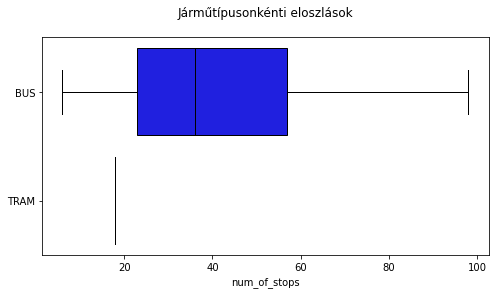

In [678]:
boxplot_sns(trips_df, 'type', 'num_of_stops')

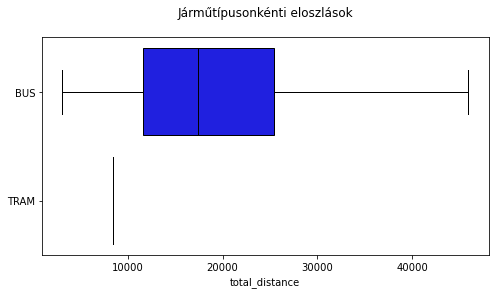

In [679]:
boxplot_sns(trips_df, 'type', 'total_distance')

In [680]:
trips_df.to_csv('route_collector/most_recent.csv', index = False)

### Concat with master

In [681]:
master = pd.read_csv('route_collector/master.csv')

In [682]:
master.shape

(320, 7)

In [683]:
trips_df.shape

(36, 8)

In [684]:
drop_list = ['tripId', 'longName', 'innerInternal']
for i in drop_list:
    if i in trips_df.columns:
        trips_df.drop(i, 1, inplace = True)
        
trips_df.columns = ['id', 'num_of_stops_MR', 'total_distance_MR', 'shortName', 'type_MR', 'From_MR', 'To_MR']

In [685]:
new_master = master.merge(trips_df, on = ['id', 'shortName'], how = 'outer')

In [686]:
new_master['From'].fillna(new_master['From_MR'], inplace = True)
new_master['To'].fillna(new_master['To_MR'], inplace = True)
new_master['type'].fillna(new_master['type_MR'], inplace = True)

new_master['num_of_stops'].fillna(new_master['num_of_stops_MR'], inplace = True)
new_master['total_distance'].fillna(new_master['total_distance_MR'], inplace = True)

In [687]:
new_master['num_of_stops'] = new_master[['num_of_stops_MR', 'num_of_stops']].max(axis=1)
new_master['total_distance'] = new_master[['total_distance_MR', 'total_distance']].max(axis=1)

In [688]:
drop_MR = new_master.filter(like = 'MR').columns.tolist()
new_master.drop(drop_MR, 1, inplace = True)

In [689]:
new_master[new_master.duplicated('id', keep = False)]

,id,num_of_stops,total_distance,shortName,type,From,To


In [690]:
new_master.drop_duplicates('id', keep = 'last', inplace = True)

In [691]:
new_master.head(3)

,id,num_of_stops,total_distance,shortName,type,From,To
0,BKK_0540,33.0,16722.0,54,BUS,"Péterimajor, Víztorony tér",Boráros tér H
1,BKK_VP50,7.0,3093.0,50,BUS,Lajosmizsei sorompó,Határ út M
2,BKK_3020,12.0,6070.0,2,TRAM,Jászai Mari tér,Közvágóhíd H


In [692]:
new_items = np.setdiff1d(new_master['id'].unique(), master['id'].unique()).tolist()

In [693]:
new_master[new_master['id'].isin(new_items)]

,id,num_of_stops,total_distance,shortName,type,From,To


In [669]:
new_master.to_csv('route_collector/master.csv', index = False)

#### Which ones are still missing?

In [670]:
routes = pd.DataFrame.from_dict(stops['references']['routes'], orient = 'index')\
                     .reset_index(drop = True)\
                     .drop(['color', 'textColor', 'agencyId', 'iconDisplayType', 'iconDisplayText', 'style', 'sortOrder', 'bikesAllowed'], 1)

routes[['From', 'To']] = routes['description'].str.split('|', expand = True)
routes['To'] = routes['To'].str.strip()
routes['From'] = routes['From'].str.strip()
routes.drop(['description'], 1, inplace = True)

routes.head(3)

,id,shortName,type,From,To
0,BKK_9960,996,BUS,Cinkotai autóbuszgarázs,Újpest-központ M
1,BKK_9720,972,BUS,"Törökbálint, Nyár utca",Móricz Zs. körtér M
2,BKK_9961,996A,BUS,Cinkotai autóbuszgarázs,Újpest-központ M


In [671]:
routes[(routes['id'].isin(np.setdiff1d(routes['id'].unique(), new_master['id'].unique()))) & 
       (~routes['id'].str.contains('MP|HP|VP|KT'))& 
       (~routes['type'].isin(['SUBWAY', 'FERRY']))].shape

(36, 5)

In [672]:
routes[(routes['id'].isin(np.setdiff1d(routes['id'].unique(), new_master['id'].unique()))) & 
       (~routes['id'].str.contains('MP|HP|VP|KT'))& 
       (~routes['type'].isin(['SUBWAY', 'FERRY']))]

,id,shortName,type,From,To
11,BKK_2410,241,BUS,Lomnici utca,Savoya Park
16,BKK_2411,241A,BUS,Lomnici utca,Városház tér
33,BKK_0362,36B,BUS,Gubacsi út / Határ út / Szentlőrinci úti lakót...,None
42,BKK_9141,914A,BUS,Újpest-központ M,Határ út M
61,BKK_3282,28B,TRAM,Keleti pályaudvar M / Új köztemető (Kozma utca),None
65,BKK_9380,938,BUS,Szigetszentmiklós,"Csepel, Szent Imre tér"
67,BKK_4810,81,TROLLEYBUS,Fischer István utca,Örs vezér tere M H
68,BKK_3600,60,TRAM,"Városmajor / Széchenyi-hegy, Gyermekvasút",None
85,BKK_9920,992,BUS,Gödöllő H,Cinkotai autóbuszgarázs
93,BKK_3027,N2,TRAM,Nosztalgiajárat,Nosztalgiajárat
